
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Giant Hogweed Detection</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Names</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://lizzieharper.co.uk/wp-content/uploads/2023/03/Giant-Hogweed-Heracleum-mantegazzianum-lo-371x525.jpg" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

- Client: Sieuwe Elferink
- Instructors: Bob Tuinman, Pascal van den Bosch
- Date: 21-6-2024 

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Table of contents </strong></h2>
</div>
<ul style="padding: 0; list-style: none;">
    <li style="text-align: center;"><a href="#1.0">Chapter 1: Project</a></li>
    <li style="text-align: center;"><a href="#1.0">Chapter 2: Loading Data</a></li>
    <li style="text-align: center;"><a href="#2.0">Chapter 3: Exploratory Data Analysis</a></li>
    <li style="text-align: center;"><a href="#3.0">Chapter 4: Different Models</a></li>
    <li style="text-align: center;"><a href="#5.0">Chapter 5: Using own data on trained models</a></li>
    <li style="text-align: center;"><a href="#6.0">Chapter 6: Best Model</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 7: API to call the best model</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 8: Results and Conclusions</a></li>
    <li style="text-align: center;"><a href="#8.0">Chapter 9: Sources</a></li>
</ul>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 1: Project </strong></h2>

</ul>

The giant hogweed is a plant that causes a lot of nuisance and if you touch it, you can get severe burns. This is due to the sap of the plant. The common hogweed, on the other hand, does not cause such problems and is much less dangerous. You can distinguish the giant hogweed from the common hogweed by its coarse, large leaves and rapid growth compared to the more modest, finer leaves of the common hogweed.

Our project faces several complications. One of the biggest challenges is the lack of available drone data, which is essential for training the model to detect the hogweed. Since we do not have this data available, we have to make our own drone recordings and then create masks for image recognition. This process is very time-consuming.

In addition, there are other challenges associated with obtaining this data. Flying drones requires specific permits and safety measures, especially in areas where the giant hogweed grows, which are often difficult to access.

Despite these challenges, we are determined to find solutions and make our project a success.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 2: Loading data </strong></h2>

</ul>

**Packages**

In [1]:
import os
import requests
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Input, ReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import concatenate, UpSampling2D, Conv2DTranspose, BatchNormalization, Add, Concatenate

**Own defined functions**

In [2]:
def preprocess_mask(mask):
    mask = mask / 255.0
    return mask

In [3]:
def display_images(display_list, title_list):
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title_list[i])
        if len(display_list[i].shape) == 2:
            display_image = tf.expand_dims(display_list[i], axis=-1)  
        else:
            display_image = display_list[i]
        plt.imshow(tf.keras.utils.array_to_img(display_image))
        plt.axis('off')
    plt.show()

In [4]:
def augment_image(image, mask):
    image_data_gen = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
    mask_data_gen = ImageDataGenerator(rotation_range=20,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    seed = np.random.randint(0, 10000)
    aug_image = image_data_gen.random_transform(image, seed=seed)
    aug_mask = mask_data_gen.random_transform(mask, seed=seed)

    return aug_image, aug_mask

In [5]:
def parse_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = preprocess_mask(mask)

    if tf.random.uniform(()) > 0.5:
        img, mask = tf.numpy_function(augment_image, [img, mask], [tf.float32, tf.float32])

    return img, mask

In [6]:
def tfdata_generator(image_files, mask_files, batch_size, seed=42):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.shuffle(buffer_size=len(image_files), seed=seed)
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat() 
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [7]:
def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

In [8]:
def split_image(image, patch_size=256):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

def merge_patches(patches, image_shape, patch_size=256):
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, 1))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            patch_h, patch_w, _ = patch.shape
            if i + patch_h > h or j + patch_w > w:
                patch = patch[:h-i, :w-j, :] 
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch
            patch_index += 1
    return reconstructed_image

def load_single_image(image_path, target_size=None):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    return image

In [9]:
def plot_loss(history):
    plt.figure(figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation Losses', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], color='lightgray', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['IoU'], label='Training IoU', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_IoU'], label='Validation IoU', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation IoU', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('IoU', fontsize=14)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['IoU'])), history.history['IoU'], history.history['val_IoU'], color='lightgray', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [10]:
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [11]:
def display_prediction_images(input_image, predicted_mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

In [12]:
def visualize_results(model, images, masks):
    predictions = model.predict(images)
    for i in range(len(images)):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.axis('off')
        
        plt.show()

**Here, we split the data into smaller images of 256x256 pixels to increase the amount of available data and to ensure the photos are not too large to load.**

```python


def split_and_save_images(image_dir, output_dir, patch_size=256):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_names = os.listdir(image_dir)

    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            width, height = image.size

            num_patches_x = width // patch_size
            num_patches_y = height // patch_size

            for i in range(num_patches_x):
                for j in range(num_patches_y):
                    left = i * patch_size
                    upper = j * patch_size
                    right = (i + 1) * patch_size
                    lower = (j + 1) * patch_size
                    
                    patch = image.crop((left, upper, right, lower))
                    patch_name = f"{file_name.split('.')[0]}_patch_{i}_{j}.jpg"
                    patch.save(os.path.join(output_dir, patch_name))

image_dir = 'eigen masks/images'
output_dir = 'eigen masks/image_patches'
split_and_save_images(image_dir, output_dir)

mask_dir = 'eigen masks/masks'
output_dir = 'eigen masks/mask_patches'
split_and_save_images(mask_dir, output_dir)

**Loading images & masks**

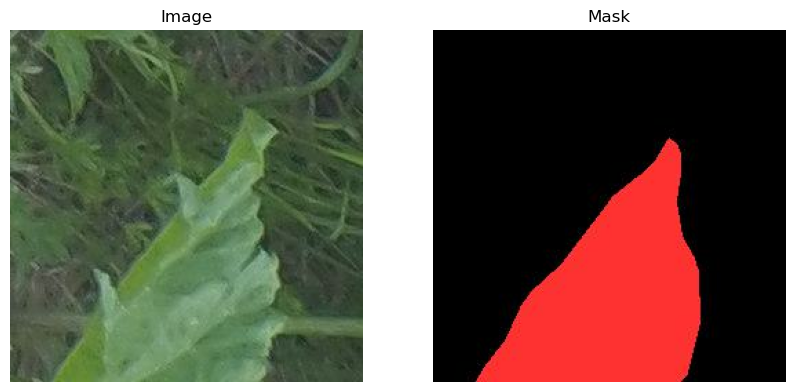

In [13]:
image_dir = 'self-labeled data/image_patches'
mask_dir = 'self-labeled data/mask_patches'
batch_size = 64

image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]
mask_files = [os.path.join(mask_dir, msk) for msk in os.listdir(mask_dir) if msk.endswith('.jpg')]

if image_files and mask_files:
    img_path = image_files[0]
    mask_path = mask_files[0]
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    plt.show()

**Split the data in training and test sets**

In [18]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

train_dataset = tfdata_generator(train_images, train_masks, batch_size)
test_dataset = tfdata_generator(test_images, test_masks, batch_size)

steps_per_epoch = len(train_images) // batch_size
validation_steps = len(test_images) // batch_size

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 3: Exploratory Data Analysis </strong></h2>
</div>

In [ ]:
num_images_without_masks = sum(np.all(mask == 0) for mask in train_masks)
percentage_without_masks = num_images_without_masks / len(train_masks) * 100

print(f"Number of images in the dataset: {len(train_masks)}")
print(f"Number of images with masks: {len(train_masks) - num_images_without_masks}")
print(f"Number of images without masks: {num_images_without_masks}")
print(f"Percentage of images with masks: {100 - round(percentage_without_masks, 2)}%")
print(f"Percentage of images without masks: {round(percentage_without_masks, 2)}%")

In [ ]:
print(f"Afbeelding lengte en breedte: {train_images[0].shape}")

In [ ]:
data = []

for i in range(len(images)):
    height, width, channels = images[i].shape
    size = height * width
    has_mask = np.any(masks[i])
    mask_coverage = np.sum(masks[i]) / size
    aspect_ratio = width / height
    avg_color = np.mean(images[i], axis=(0, 1)) / 255  
    avg_color_hex = mcolors.rgb2hex(avg_color)
    
    color_std = np.std(images[i], axis=(0, 1)) / 255
    brightness = np.mean(images[i]) / 255
    gray_image = rgb2gray(images[i])
    contrast = np.std(gray_image)

    data.append([i, width, height, size, has_mask, mask_coverage, avg_color, avg_color_hex, color_std, brightness, contrast])

images_info = pd.DataFrame(data, columns=['image_id', 'Breedte', 'Hoogte', 'Grootte'
                                          , 'Heeft een mask', 'Mask bedekking', 'Verdeling kleuren'
                                          , 'Gemiddelde kleur HTML', 'Kleurvariatie', 'Helderheid'
                                          , 'Contrast'])

images_info.head(10)

1.	Image ID: This is a unique identifier for each image in the dataset. In this case, it is the index of the image in the list images. For example, 0 means this is the first image in the list. It is important to be able to identify each image, especially if you want to refer to specific images later.

2.	Width: This is the width of the image in pixels. In this case, the width is 224 pixels. Knowing the dimensions of the image can be useful when analyzing the image, for example, to understand how the size of the image affects the mask coverage.

3.	Height: This is the height of the image in pixels. In this case, the height is 224 pixels. Like the width, the height can be useful when analyzing the image.

4.	Size: This is the total number of pixels in the image, calculated as width x height. In this case, the size is 50176 pixels. This can be useful when analyzing the image, for example, to understand how the size of the image affects the mask coverage.

5.	Has Mask: This indicates whether the image has an associated mask. In this case, the image does not have a mask (False). This can be useful when analyzing the image, for example, to understand how the presence of a mask affects other characteristics of the image.

6.	Mask Coverage: This is the percentage of the image that is covered by the mask, calculated as the number of mask pixels divided by the total number of pixels. In this case, the mask coverage is 0.000000, which means there is no mask. This can be useful when analyzing the image, for example, to understand how the mask coverage affects other characteristics of the image.

7.	Color Distribution: This is the average color of the image, calculated as the average RGB value of all pixels and normalized between 0 and 1. In this case, the average color is [0.3177765, 0.31320137, 0.20988709], which is a dark brown color. Knowing the average color can be useful when analyzing the image to understand how different the colors are.

8.	Average Color HTML: This is the average color of the image converted to an HTML color (hexadecimal color code). In this case, the average color is #515036, which corresponds to the RGB color in the ‘Color Distribution’ column. Knowing the HTML color can be useful for visualization purposes, for example, to create an overview of the average colors of the images.

9.	Color Variation: This is the standard deviation of the colors in the image, calculated as the standard deviation of the RGB values of all pixels and normalized between 0 and 1. In this case, the color variation is [0.18607375, 0.18607375, 0.18607375], which means that the colors in the image do not vary much. Knowing the color variation can be useful when analyzing the image, for example, to understand how uniform the colors are.

10.	Brightness: This is the average brightness of the image, calculated as the average brightness of all pixels and normalized between 0 and 1. In this case, the brightness is 0.31320137, which means that the image is not very bright. Knowing the brightness can be useful when analyzing the image, for example, to understand how light or dark the image is.

11.	Contrast: This is the contrast value of the image, calculated as the standard deviation of the grayscale values of the image. In this case, the contrast is 0.18607375, which means that the image has an average contrast. Knowing the contrast can be useful when analyzing the image, for example, to understand how sharp the transitions between light and dark areas are.

In [ ]:
images_info[['Kleurvariatie', 'Helderheid', 'Contrast']].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(images_info['Mask bedekking'], bins=50)
plt.xlabel('Mask Coverage')
plt.ylabel('Count')
plt.title('Distribution of mask coverage')
plt.show()

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 4: Different Models </strong></h2>
</div>

### **Literature Review and Models**
For our task of detecting giant hogweed through pixel segmentation, it is important to use models that can segment accurately and in detail. Based on literature studies, we have made a good selection of deep learning models to achieve the best results for our task. These models are specifically designed for pixel segmentation tasks. Below, we have summarized what the papers consider to be the best models.




**Paper: "Comparison of Deep-Learning-Based Segmentation Models: Using Top View Person Images" by Imran Ahmed, Misbah Ahmad, Fakhri Alam Khan, and Muhammad Asif**

- U-Net:
    - Architecture: U-Net has an encoder-decoder structure with symmetric connections between the downsampling and upsampling paths, helping to retain detailed spatial information.
    - Performance: The model provides high accuracy in segmentation tasks by utilizing low- and high-resolution features.

- DeepLabV3:
    - Architecture: DeepLabV3 uses atrous convolutions to preserve high-resolution features without significantly increasing computational time. It uses ResNet-101 as a base and integrates parallel and consecutive modules of atrous convolutions.
    - Performance: DeepLabV3 outperforms many other models in terms of accuracy and preserving detailed objects. The model provides good results even in complex images and different lighting conditions.

- Fully Convolutional Network (FCN):
    - Architecture: FCN replaces fully connected layers with convolutional layers, allowing for dense pixel predictions. The model uses upsampling to generate output of the same size as the input.
    - Performance: FCN is often used as a baseline for other segmentation models due to its robust and good segmentation results. Although it may not always offer the highest accuracy, it is fast and effective for many applications.


**Paper: "Understanding Deep Learning Techniques for Image Segmentation" by Swarnendu Ghosh, Nibaran Das, Ishita Das, and Ujjwal Maulik**

- Deep Layer Cascade:
    - Why Good? This model operates in multiple stages where easily segmented areas are segmented immediately, and more difficult areas in later stages. This approach improves the speed and accuracy of segmentation.
    - Performance: Achieves an average Intersection over Union (IoU) of 82.7 on the VOC12 test set.

- DeepLab:
    - Why Good? DeepLab uses dilated convolutions, meaning the filter is expanded by skipping intermediate pixels during the operation (atrous), and fully connected conditional random fields (CRFs) to enhance contextual information without losing segmentation resolution, resulting in sharper segmentation output.
    - Performance: Achieves an average IoU of 79.7 on the PASCAL VOC 2012 dataset.

- PSPNet (Pyramid Scene Parsing Network):
    - Why Good? This model utilizes spatial pyramid pooling to leverage features at different scales, aiding in segmenting objects of different sizes in real environments.
    - Performance: Scores an average IoU of 57.21 on the ImageNet Scene Parsing Challenge.



**Paper: "A Review on Deep Learning Techniques Applied to Semantic Segmentation" by A. Garcia-Garcia, S. Orts-Escolano, S.O. Oprea, V. Villena-Martinez, and J. Garcia-Rodriguez**

- Fully Convolutional Networks (FCNs):
    - Description: FCNs have transformed traditional convolutional neural networks (CNNs) by replacing fully connected layers with convolutional layers that provide spatial maps instead of classification scores.
    - Reason for Success: This model can be trained end-to-end for semantic segmentation, enabling efficient and accurate predictions for each pixel. FCNs have demonstrated significant improvements in segmentation accuracy on datasets such as PASCAL VOC.

- DeepLab:
    - Description: DeepLab utilizes atrous convolutions, spatial pooling pyramids, and fully connected conditional random fields (CRFs).
    - Reason for Success: Atrous convolutions expand the field of view without increasing the number of parameters, helping to capture information without reducing segmentation sharpness. DeepLab achieved a high mean IoU of 79.7 on the PASCAL VOC 2012 dataset.

- DAG-RNN (Directed Acyclic Graph Recurrent Neural Network):
    - Description: This model uses a directed graph structure to model contextual information.
    - Reason for Success: DAG-RNN has achieved high accuracy on datasets such as CamVid (91.60 IoU) through context modeling.









### **Selected Models for Our Application**

Based on the mentioned papers and the specific requirements for detecting giant hogweed, we have selected the following models that we will use.

- U-Net:

    - Reason for choice: The encoder-decoder architecture with connections provides detailed segmentation and retains spatial information, crucial for the accurate detection of giant hogweed.

- DeepLab (DeepLabV3):

    - Reason for choice: The application of atrous convolutions and conditional random fields provides sharp segmentation output and effective information processing, which is particularly useful in complex images.

- Fully Convolutional Network (FCN):

    - Reason for choice: As a fast and robust model, FCN offers a good balance between speed and accuracy, which is important for real-time applications.

- Deep Layer Cascade:

    - Reason for choice:

With these models, we aim to achieve optimal performance in detecting and segmenting giant hogweed in images, enabling us to obtain accurate location information for further analysis.


### **U-net**

##### Decoder & Encoder

In [32]:
def unet_model(input_size=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_size)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

model_unet = unet_model()

##### Compile the model

In [33]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

model_unet.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=[iou])

checkpoint_filepath = '/models/u-net/model_unet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', save_best_only=True)

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

##### Train the model

In [ ]:
history_unet = model_unet.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=1, validation_data=test_dataset, validation_steps=validation_steps, callbacks=model_checkpoint_callback)

##### Model Evaluation

In [ ]:
plot_loss(history_unet)

In [ ]:
visualize_results(model_unet, test_images[:5], test_masks[:5])

### **DeepLab**

##### Define the model

In [19]:
def DeepLabV3Plus(image_size):
    model_input = Input(shape=(image_size, image_size, 3))
    base_model = DenseNet121(weights='imagenet', input_tensor=model_input, include_top=False)

    x = base_model.get_layer("relu").output 
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)  
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)  
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(1, (1, 1), padding='same')(x)
    x = Activation('sigmoid')(x)
    
    return Model(inputs=base_model.input, outputs=x)

image_size = 256 
model_deeplab = DeepLabV3Plus(image_size)

##### Compile the model

In [ ]:
model_deeplab.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

model_deeplab.summary()

##### Train the model

In [ ]:
history_deeplab = model_deeplab.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=2, validation_data=test_dataset, validation_steps=validation_steps)

##### Model evaluation

In [ ]:
plot_loss(history_deeplab)

In [ ]:
visualize_results(model_deeplab, test_images[:5], test_masks[:5])

### **Fully Convolutional Network (FCN)**

### **Deep Layer Cascade**

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 5: Using own data on trained models </strong></h2>
</div>

In [ ]:
def split_image(image, patch_size=256):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

def merge_patches(patches, image_shape, patch_size=256):
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, 1))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            patch_h, patch_w, _ = patch.shape
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch
            patch_index += 1
    return reconstructed_image

# Load your own image
def load_single_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    return image

# Provide the path to your own image
own_image_path = 'eigen data/your_image.jpg'
own_image = load_single_image(own_image_path, target_size=None)  

# Split the image into 256x256 patches
patches = split_image(own_image, patch_size=256)

# Make predictions for each patch
patches_array = np.array(patches)
pred_patches = model.predict(patches_array)
pred_patches_thresholded = threshold_predictions(pred_patches, threshold=0.5)

# Merge the predicted patches into one complete image
reconstructed_mask = merge_patches(pred_patches_thresholded, own_image.shape, patch_size=256)

# Display the results
display_prediction_images(own_image, reconstructed_mask)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 6: Best Model </strong></h2>
</div>

##### Collecting IoU scores

In [ ]:
iou_unet = history_unet['iou']
iou_deeplab = history_deeplab['iou']
iou_fcn = history_fcn['iou']
iou_dlc = history_dlc['iou']

final_iou_scores = {
    'U-net': iou_unet[-1],
    'Deeplab': iou_deeplab[-1],
    'Fully Convolutional Network': iou_fcn[-1],
    'Deep Layer Cascade': iou_dlc[-1]
}

##### Visualize the different models

In [ ]:
plt.figure(figsize=(12, 8))
bars = plt.bar(final_iou_scores.keys(), final_iou_scores.values(), color=['blue', 'orange', 'green', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  

plt.title('Final IoU Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('IoU Score')

plt.show()

epochs = np.arange(1, len(iou_unet) + 1)
plt.figure(figsize=(12, 8))
plt.plot(epochs, iou_unet, label='U-net')
plt.plot(epochs, iou_deeplab, label='Deeplab')
plt.plot(epochs, iou_fcn, label='Fully Convolutional Network')
plt.plot(epochs, iou_dlc, label='Deep Layer Cascade')

plt.title('IoU Scores Across Epochs for Different Models')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

##### The different predictions

In [ ]:
def load_test_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size) 
    image = img_to_array(image) / 255.0
    return np.expand_dims(image, axis=0) 

def plot_predictions(image_path, models, model_names, target_size=(256, 256)):
    test_image = load_test_image(image_path, target_size)
    
    fig, axes = plt.subplots(1, len(models) + 1, figsize=(20, 5))

    original_image = load_img(image_path, target_size=target_size)
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, model in enumerate(models):
        prediction = model.predict(test_image)[0, :, :, 0]
        axes[i + 1].imshow(prediction, cmap='gray')
        axes[i + 1].set_title(f"Prediction by {model_names[i]}")
        axes[i + 1].axis('off')
    
    plt.show()

test_image_path = 'self-labeled data/image_patches/0099_patch_3_1.jpg' 
models = [model_unet, model_deeplab, model_fcn, model_dlc]
model_names = ['U-net', 'Deeplab', 'Fully Convolutional Network', 'Deep Layer Cascade']

plot_predictions(test_image_path, models, model_names)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 7: API to call the best model </strong></h2>
</div>

When the file ‘fast_api.py’ is running, you can execute this code to invoke the model on your own image.

In [ ]:
url = 'http://127.0.0.1:8000/predict/'
file_path = 'eigen data/IMG_4490.jpeg'

with open(file_path, 'rb') as f:
    response = requests.post(url, files={'file': f})

print(f"Status code: {response.status_code}")

try:
    json_response = response.json()
    print(f"Size of JSON response: {len(response.text)} characters")

    prediction = np.array(json_response['prediction'])

    original_image = plt.imread(file_path)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()
except ValueError as e:
    print("Error parsing JSON response:", e)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 8: Results and Conclusions </strong></h2>
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 9: Sources </strong></h2>
</div>

- _GeeksforGeeks. (2022, 1 augustus). Image segmentation using TensorFlow. GeeksforGeeks._ https://www.geeksforgeeks.org/image-segmentation-using-tensorflow/